In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Objective

<p> Train a classifier to identify 3 types of women's footwear using fastai library
    
    - Stilettos
    - Boots
    - Sneakers
    
The data will be gathered from image search on google.
    
    

In [2]:
from fastai.vision import *

# Collecting Data

<p> We use Google images to search for the data.

- For each category we issue google image query
- We then collect the url's in a csv file as shown by the fastai lesson2
- We download data for each category and then attempt to remove the data that was not cleanly downloaded

In [8]:
'''
Setup data directory and return its path instance

For each category it will setup a path as follows

'''
def get_data_path(root, categories):
    path = Path(root + '/footwear')
    for category in categories:
        dest = path/category
        dest.mkdir(parents=True, exist_ok=True)
    return path
        

'''
Download data for each category. Delete images not correctly downloaded

Obtain csv containing urls for searched image category by running following
command in JS console of chrome browser
urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
'''
def download_data(path, categories, categories_csv):
    for i in range(0,len(categories_csv)):
        download_images(path/categories_csv[i], path/categories[i], max_pics=300, max_workers=0)

    for category in categories:
        verify_images(path/category, delete=True, max_size=500)
 

In [9]:
classes = ['boots', 'sneakers', 'stilettos']
root = ['/Users/Gunners/fastai/data']
path = get_data_path('/Users/Gunners/fastai/data', classes)

In [12]:
categories_csv = ['boots.csv', 'sneakers.csv', 'stilettos.csv']
download_data(path, classes, categories_csv)

In [14]:
path.ls()

[PosixPath('/Users/Gunners/fastai/data/footwear/boots'),
 PosixPath('/Users/Gunners/fastai/data/footwear/stilettos'),
 PosixPath('/Users/Gunners/fastai/data/footwear/sneakers'),
 PosixPath('/Users/Gunners/fastai/data/footwear/sneakers.csv'),
 PosixPath('/Users/Gunners/fastai/data/footwear/stilettos.csv'),
 PosixPath('/Users/Gunners/fastai/data/footwear/boots.csv')]

# Prepare Data Bunch

<p>Use the data directory setup above to prepare the data bunch.  
    
   - We will use the validation split of 0.2,  
   - the imagenet stats for normalization of the pixel values  
   - the standard set of transforms  
   - image size of 224  

In [20]:
np.random.seed(42)
db = ImageDataBunch.from_folder(path, train='.', valid_pct=0.2,
                                ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [21]:
db.classes

['boots', 'sneakers', 'stilettos']

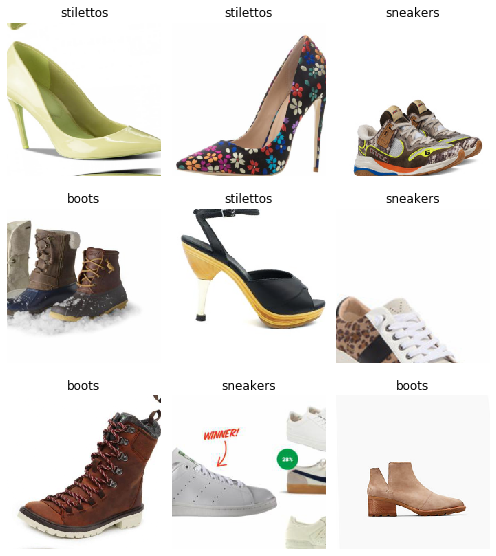

In [22]:
db.show_batch(rows=3, figsize=(7,8))

In [24]:
len(db.train_ds), len(db.valid_ds)

(689, 172)

# Training the model
<p> We use resent34 based model to do the training. First we will only train the fully connected layers and evaluate the performance

In [26]:
learner = cnn_learner(db, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /Users/Gunners/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:32<00:00, 2.69MB/s]


In [27]:
learner.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.366929,0.327978,0.087209,03:33
1,0.774560,0.398343,0.093023,03:33
2,0.552073,0.379687,0.104651,03:31
3,0.448459,0.349173,0.093023,03:31


In [28]:
learner.save('stage-1')

We will now attempt to train the rest of the model

In [30]:
learner.unfreeze()

In [31]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


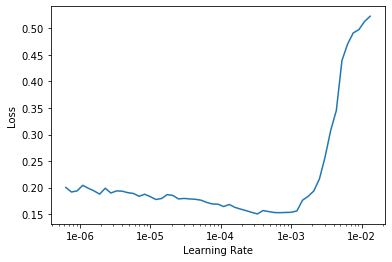

In [32]:
learner.recorder.plot()


In [35]:
learner.fit_one_cycle(2, max_lr=slice(1e-3, 1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,1.398620,397.403809,0.651163,05:11
1,1.257593,34.348141,0.616279,04:52


In [37]:
learner.save('stage-2')

# Inference

We use the stage 1 weights to evaluate the inference capabilities.


In [39]:
learner.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (689 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
boots,boots,boots,boots,boots
Path: /Users/Gunners/fastai/data/footwear;

Valid: LabelList (172 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
sneakers,sneakers,boots,boots,stilettos
Path: /Users/Gunners/fastai/data/footwear;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchN

In [40]:
interpreter = ClassificationInterpretation.from_learner(learner)

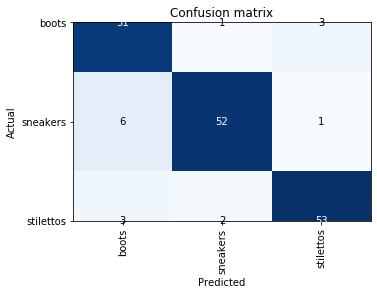

In [41]:
interpreter.plot_confusion_matrix()

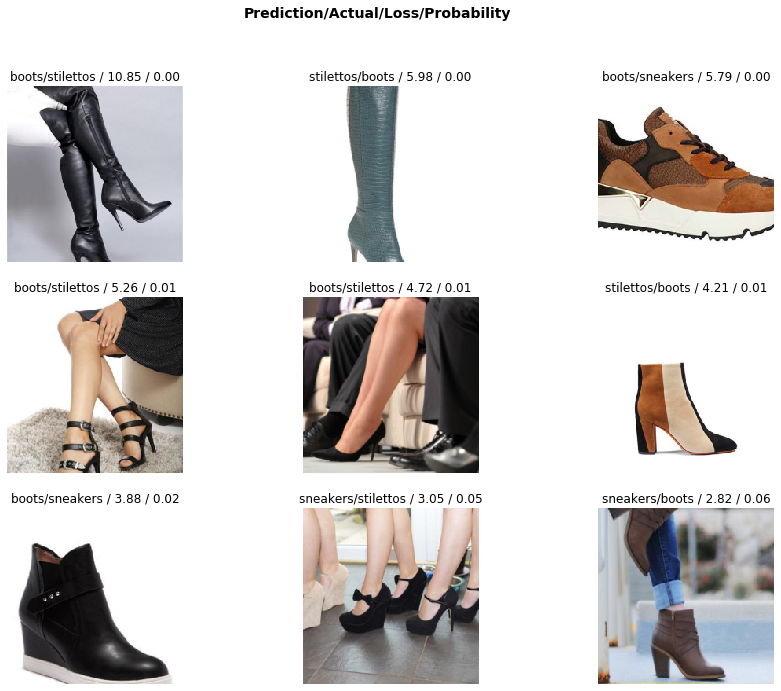

In [42]:
interpreter.plot_top_losses(9, figsize=(15,11))